In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
!unzip "/content/drive/MyDrive/L4_datos.zip"

Archive:  /content/drive/MyDrive/L4_datos.zip
replace data/Comunas/comunas.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/Comunas/comunas.prj  
  inflating: data/Comunas/comunas.sbn  
  inflating: data/Comunas/comunas.shp  
  inflating: data/Comunas/comunas.CPG  
  inflating: data/Comunas/comunas.sbx  
  inflating: data/Comunas/comunas.shp.xml  
  inflating: data/Comunas/comunas.shx  
  inflating: data/Comunas/comunas.dbf  
  inflating: data/Seguridad/seguridad_santiago.csv  
  inflating: data/Distritos Censales/Distritos Censales RM.qpj  
  inflating: data/Distritos Censales/Distritos Censales RM.prj  
  inflating: data/Distritos Censales/centroides Distritos Censales RM.qpj  
  inflating: data/Distritos Censales/centroides Distritos Censales RM.prj  
  inflating: data/Distritos Censales/centroides Distritos Censales RM.dbf  
  inflating: data/Distritos Censales/Distritos Censales RM.shx  
  inflating: data/Distritos Censales/Distritos Censales RM.shp  
  inflating: da

In [19]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import HeatMap

**A.**

Para esto voy a usar las areas de distritos censales RM que son los distritos. Verifico que tengan igual CRS y si no lo cambio.

In [20]:
# Cargar los polígonos de los distritos censales
areas = gpd.read_file('data/Distritos Censales/Distritos Censales RM.shp')
gdf_criticos = gpd.read_file('data/Accidentes/Puntos_criticos_2019.geojson')

print(f"CRS de Distritos Censales: {areas.crs}")
print(f"CRS de Puntos Críticos: {gdf_criticos.crs}")


if areas.crs != gdf_criticos.crs:
    print("Los CRS son diferentes. Transformando el CRS de los puntos críticos...")
    gdf_criticos = gdf_criticos.to_crs(areas.crs)
    print(f"Nuevo CRS de Puntos Críticos: {gdf_criticos.crs}")

print("\nCRS unificados. Listo para el análisis espacial.")

CRS de Distritos Censales: EPSG:32719
CRS de Puntos Críticos: EPSG:4326
Los CRS son diferentes. Transformando el CRS de los puntos críticos...
Nuevo CRS de Puntos Críticos: EPSG:32719

CRS unificados. Listo para el análisis espacial.


Realizo una union espacial que cuenta los puntos criticos dentro de cada poligono.

In [21]:
distritos_con_accidentes = gpd.sjoin(areas, gdf_criticos, how="left", predicate="contains")

accidentes_por_distrito = distritos_con_accidentes.groupby('CODIGO').size().reset_index(name='n_accidentes')


areas_final = areas.merge(accidentes_por_distrito, on='CODIGO', how='left')

areas_final['n_accidentes'] = areas_final['n_accidentes'].fillna(0).astype(int)

print("Conteo de accidentes por distrito censal:")
print(areas_final[['NOM_COM', 'NOM_DIS', 'n_accidentes']].sort_values('n_accidentes', ascending=False).head(10))

Conteo de accidentes por distrito censal:
              NOM_COM            NOM_DIS  n_accidentes
29          Cerrillos          Cerrillos            23
239       Providencia   Hospital Militar            19
319       Puente Alto         San Carlos            18
237       Providencia  Parque Bustamante            15
179             Maipú     Cinco de Abril            13
354      San Bernardo          O'Higgins            12
71   Estación Central     Pila del Ganso            12
232       Providencia            Condell            12
12           Santiago            Almagro            11
198             Maipú      Los Pajaritos             9


C

Calculo la tasa de accidentes por cada 1000 hogares.

In [22]:
areas_final['tasa_acc_hogares'] = 0
mask = areas_final['ADIMARK_T'] > 0
areas_final.loc[mask, 'tasa_acc_hogares'] = (areas_final['n_accidentes'] / areas_final['ADIMARK_T'] * 1000)

print("\nDistritos con mayor tasa de accidentes por cada 1000 hogares:")
print(areas_final[['NOM_COM', 'NOM_DIS', 'n_accidentes', 'ADIMARK_T', 'tasa_acc_hogares']].sort_values('tasa_acc_hogares', ascending=False).head(10))


Distritos con mayor tasa de accidentes por cada 1000 hogares:
               NOM_COM              NOM_DIS  n_accidentes  ADIMARK_T  \
182              Maipú  Feria Internacional             4      176.0   
438      Isla De Maipo              Rosario             1       48.0   
409              Alhue                Carén             1       71.0   
422        María Pinto            El Parrón             1       78.0   
414           Curacaví                Carén             1       83.0   
335  San José De Maipo           Queltehues             1       89.0   
252          Quilicura          San Ignacio             2      178.0   
29           Cerrillos            Cerrillos            23     2144.0   
400          Melipilla     Puangue Poniente             1      102.0   
417           Curacaví                Alhué             1      105.0   

     tasa_acc_hogares  
182         22.727273  
438         20.833333  
409         14.084507  
422         12.820513  
414         12.048193  


/tmp/ipython-input-2669487965.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.17233294  1.45932142  3.35148722  0.39510075  2.75957227  0.59934073
  0.94295144  0.32711809  1.62760417  0.5312085   0.37657692  0.83822297
  3.73895309  3.38000966  3.49514563  0.75018755  0.75329567  1.39470014
  0.43365134  0.89806915  2.04813108  6.73400673  1.34228188  0.405515
  0.68166326  3.51699883  1.25156446  1.40994008  5.05050505 10.72761194
  0.54024851  0.12245898  0.55617353  0.16283993  0.19264111  0.32061558
  0.2853067   0.3257329   0.23501763  0.17565431  0.24666996  0.27359781
  0.37693178  0.23562677  0.22732439  0.26780932  0.37921881  1.25628141
  0.50735667  0.24437928  0.3192848   0.28702641  1.10570544  0.30193237
  3.17662008  0.38865138  0.78957758  0.59250481  0.17202821  0.66401062
  0.20824656  0.21331058  4.40528634  1.2254902   0.4950495   0.33444816
  0.54288817  0.27609056  0.248694

Para graficar voy a considerar el Q1 de las tasas como 'bajo', Q2 como 'alto' y todo lo de entre medio como no importante ya que el enunciado pide clasificar zonas altas y bajas. El color rojo es alta tasa de accidentes y verde baja tasa de accidentes

/tmp/ipython-input-629811808.py:27: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title='Categoría de Siniestralidad', loc='upper left', frameon=True)
/tmp/ipython-input-629811808.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Categoría de Siniestralidad', loc='upper left', frameon=True)


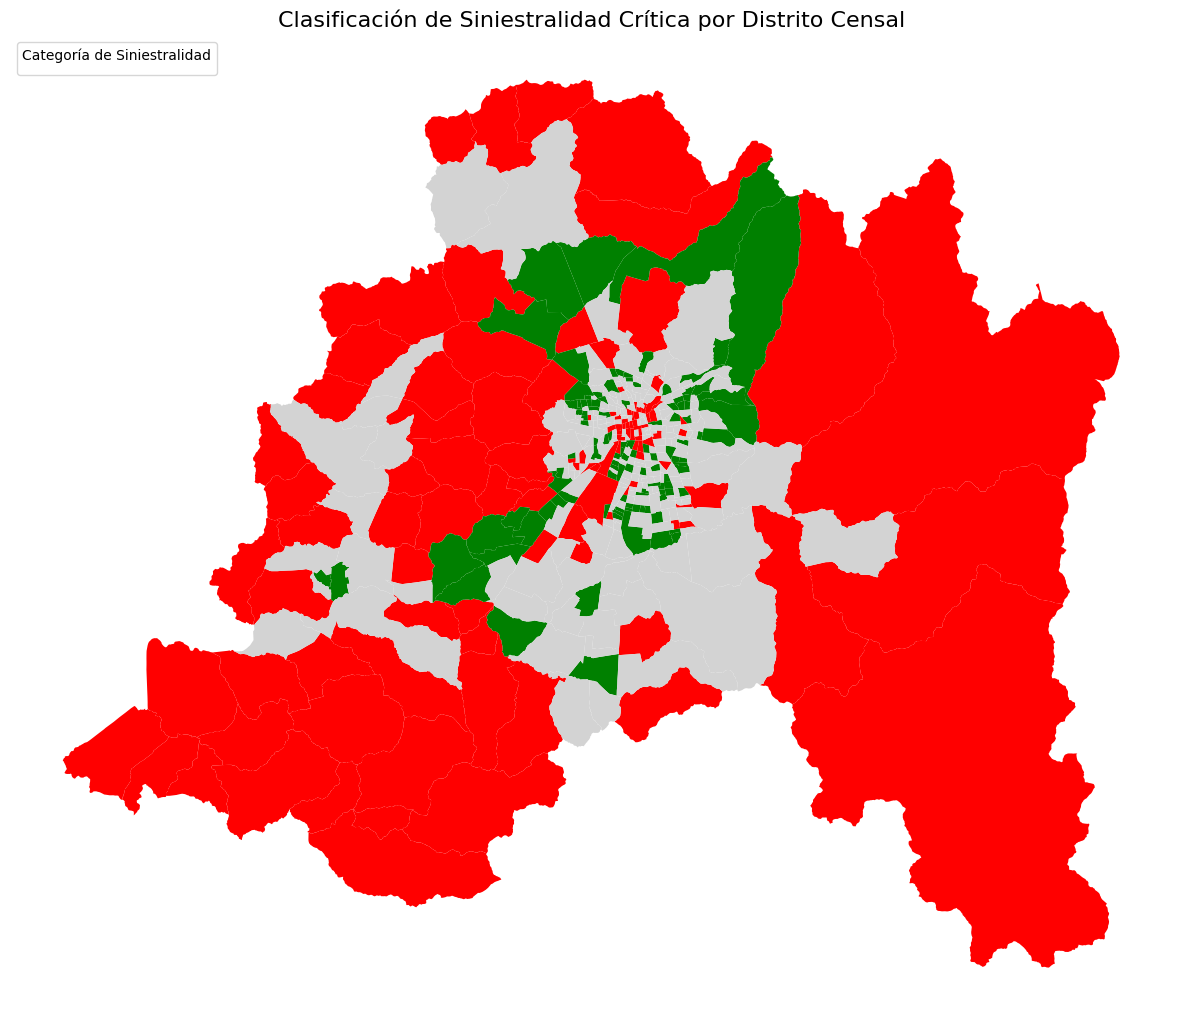

In [23]:
import matplotlib.pyplot as plt

Q1 = areas_final['tasa_acc_hogares'].quantile(0.25)
Q3 = areas_final['tasa_acc_hogares'].quantile(0.75)


def clasificar_distrito(tasa):
    if tasa >= Q3 and Q3 > 0:
        return 'Alta'
    elif tasa <= Q1:
        return 'Baja'
    else:
        return 'Intermedia'

areas_final['categoria'] = areas_final['tasa_acc_hogares'].apply(clasificar_distrito)

colores = {'Alta': 'red', 'Baja': 'green', 'Intermedia': 'lightgray'}

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

for categoria, color in colores.items():
    subset = areas_final[areas_final['categoria'] == categoria]
    subset.plot(ax=ax, color=color, label=categoria)

ax.set_title('Clasificación de Siniestralidad Crítica por Distrito Censal', fontsize=16)
ax.set_axis_off()
ax.legend(title='Categoría de Siniestralidad', loc='upper left', frameon=True)

plt.show()

**B.**

Por tiempo ya que necesito avanzar a los siguientes incisos del laboratorio cargué solamente los datos geográficos de robos y hurtos para representar la delincuencia. Luego, conté cuántos delitos ocurrieron dentro de cada distrito y calculé una tasa por cada mil hogares como en el inciso anterior para poder comparar las zonas.

In [24]:
import glob

rutas_delitos_robo = glob.glob('data/Delitos/imfd-delitos-*-robbery*/*.shp')
rutas_delitos_hurto = glob.glob('data/Delitos/imfd-delitos-*-theft*/*.shp')
rutas_delitos_totales = rutas_delitos_robo + rutas_delitos_hurto


lista_gdf_delitos = [gpd.read_file(ruta) for ruta in rutas_delitos_totales]
gdf_delitos = pd.concat(lista_gdf_delitos, ignore_index=True)

if gdf_delitos.crs != areas.crs:
    gdf_delitos = gdf_delitos.to_crs(areas.crs)

delitos_en_distritos = gpd.sjoin(areas, gdf_delitos, how="left", predicate="contains")
conteo_delitos_distrito = delitos_en_distritos.groupby('CODIGO').size().reset_index(name='n_delitos')
areas_final = areas_final.merge(conteo_delitos_distrito, on='CODIGO', how='left')
areas_final['n_delitos'] = areas_final['n_delitos'].fillna(0).astype(int)

areas_final['tasa_delitos_hogares'] = 0
mask = areas_final['ADIMARK_T'] > 0
areas_final.loc[mask, 'tasa_delitos_hogares'] = (areas_final['n_delitos'] / areas_final['ADIMARK_T'] * 1000)

/tmp/ipython-input-1945262266.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.29308324  0.36483035  0.4189359   0.19755038  0.34494653  0.29967036
  0.47147572  0.32711809  0.32552083  0.26560425  0.18828846  0.41911148
  0.33990483  0.48285852  0.38834951  0.75018755  0.37664783  0.69735007
  0.43365134  0.44903458  0.51203277  1.68350168  1.34228188  0.405515
  0.68166326  1.17233294  0.31289111  0.35248502  5.05050505  0.46641791
  0.27012426  0.12245898  0.18539118  0.16283993  0.19264111  0.32061558
  0.2853067   0.3257329   0.23501763  0.17565431  0.24666996  0.27359781
  0.37693178  0.23562677  0.22732439  0.26780932  0.1896094   0.41876047
  0.50735667  0.24437928  0.3192848   0.28702641  0.22114109  0.30193237
  0.63532402  0.38865138  0.19739439  0.1481262   0.17202821  0.16600266
  0.20824656  0.21331058  2.20264317  1.2254902   0.4950495   0.33444816
  0.54288817  0.27609056  0.24869

In [25]:
df_seguridad = pd.read_csv('data/Seguridad/seguridad_santiago.csv')

print("Las columnas en el archivo de seguridad son:")
print(df_seguridad.columns)

Las columnas en el archivo de seguridad son:
Index(['seguridad', 'lat', 'lon'], dtype='object')


Leo los puntos de percepción de seguridad y calcula el valor promedio para cada distrito censal. Invierto este valor para que una puntuación más alta signifique una peor percepción.

In [26]:

df_seguridad = pd.read_csv('data/Seguridad/seguridad_santiago.csv')

gdf_seguridad = gpd.GeoDataFrame(
    df_seguridad,
    geometry=gpd.points_from_xy(df_seguridad.lon, df_seguridad.lat),
    crs="EPSG:4326"
)

if gdf_seguridad.crs != areas.crs:
    gdf_seguridad = gdf_seguridad.to_crs(areas.crs)

seguridad_en_distritos = gpd.sjoin(areas, gdf_seguridad, how="left", predicate="contains")

seguridad_promedio = seguridad_en_distritos.groupby('CODIGO')['seguridad'].mean().reset_index(name='seguridad_promedio')

areas_final = areas_final.merge(seguridad_promedio, on='CODIGO', how='left')

media_global_seguridad = areas_final['seguridad_promedio'].mean()
areas_final['seguridad_promedio'] = areas_final['seguridad_promedio'].fillna(media_global_seguridad)

areas_final['inseguridad_promedio'] = 1 - areas_final['seguridad_promedio']

print("Indicador de inseguridad calculado y añadido.")
print(areas_final[['NOM_COM', 'inseguridad_promedio']].sort_values('inseguridad_promedio', ascending=False).head())

Indicador de inseguridad calculado y añadido.
                 NOM_COM  inseguridad_promedio
217  Pedro Aguirre Cerda              2.081978
161            Lo Espejo              1.993202
216  Pedro Aguirre Cerda              1.925501
160            Lo Espejo              1.861864
316          Puente Alto              1.809717


Filtro para las áreas urbanas de la RM

In [27]:

gdf_areas_urbanas_chile = gpd.read_file('data/Areas Urbanas/areas_urbanas.shp')

if gdf_areas_urbanas_chile.crs != areas_final.crs:
    gdf_areas_urbanas_chile = gdf_areas_urbanas_chile.to_crs(areas_final.crs)

areas_urbanas_rm = gpd.overlay(gdf_areas_urbanas_chile, areas_final, how='intersection')

limite_urbano_rm = areas_urbanas_rm.unary_union
gdf_limite_urbano_rm = gpd.GeoDataFrame(geometry=[limite_urbano_rm], crs=areas_final.crs)

distritos_finales_urbanos = gpd.clip(areas_final, gdf_limite_urbano_rm)

/tmp/ipython-input-606219761.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  limite_urbano_rm = areas_urbanas_rm.unary_union


Creo el indice de criticidad y grafico lo pedido

/tmp/ipython-input-403782208.py:49: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title='Nivel de Criticidad', loc='upper left', frameon=True)
/tmp/ipython-input-403782208.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Nivel de Criticidad', loc='upper left', frameon=True)


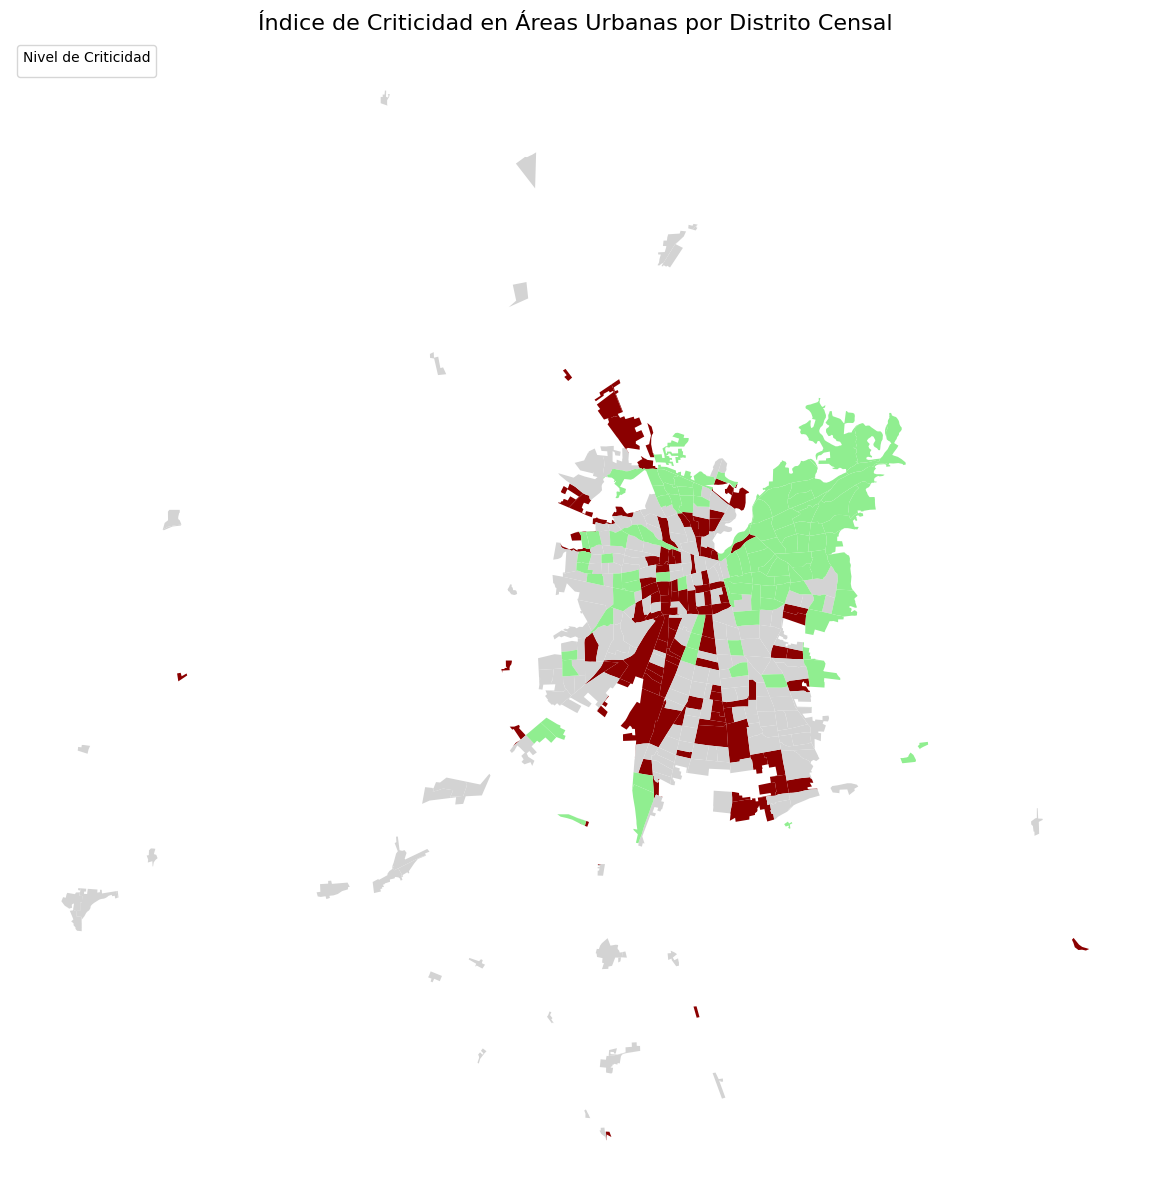

In [31]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


scaler = MinMaxScaler()
factores = ['tasa_acc_hogares', 'tasa_delitos_hogares', 'inseguridad_promedio']

distritos_finales_urbanos[factores] = scaler.fit_transform(distritos_finales_urbanos[factores])

distritos_finales_urbanos['indice_criticidad'] = distritos_finales_urbanos[factores].sum(axis=1)

Q1_crit = distritos_finales_urbanos['indice_criticidad'].quantile(0.25)
Q3_crit = distritos_finales_urbanos['indice_criticidad'].quantile(0.75)

def clasificar_criticidad(indice):
    if indice >= Q3_crit:
        return 'Crítica'
    elif indice <= Q1_crit:
        return 'Baja Criticidad'
    else:
        return 'Intermedia'

distritos_finales_urbanos['criticidad'] = distritos_finales_urbanos['indice_criticidad'].apply(clasificar_criticidad)

colores_criticidad = {'Crítica': 'darkred', 'Baja Criticidad': 'lightgreen', 'Intermedia': 'lightgray'}
categorias_ordenadas = ['Crítica', 'Intermedia', 'Baja Criticidad']

fig, ax = plt.subplots(1, 1, figsize=(15, 15))

for categoria in categorias_ordenadas:
    color = colores_criticidad[categoria]

    subconjunto = distritos_finales_urbanos[distritos_finales_urbanos['criticidad'] == categoria]

    if not subconjunto.empty:
        subconjunto.plot(ax=ax, color=color, label=categoria)

ax.set_title('Índice de Criticidad en Áreas Urbanas por Distrito Censal', fontsize=16)
ax.set_axis_off()
ax.legend(title='Nivel de Criticidad', loc='upper left', frameon=True)

plt.show()

**C.**

Nos enfocaremos solo en la RM por temas de tamaño del gráfico.

Estoy filtrando el mapa de Chile para quedarme únicamente con las comunas de la Región Metropolitana. Luego, cunto la cantidad total de delitos que ocurrieron en cada una y para poder comparar comunas de distintos tamaños calculo la densidad de delitos. El mapa me da una visión general de cuáles son las comunas con mayor concentración de delincuencia.

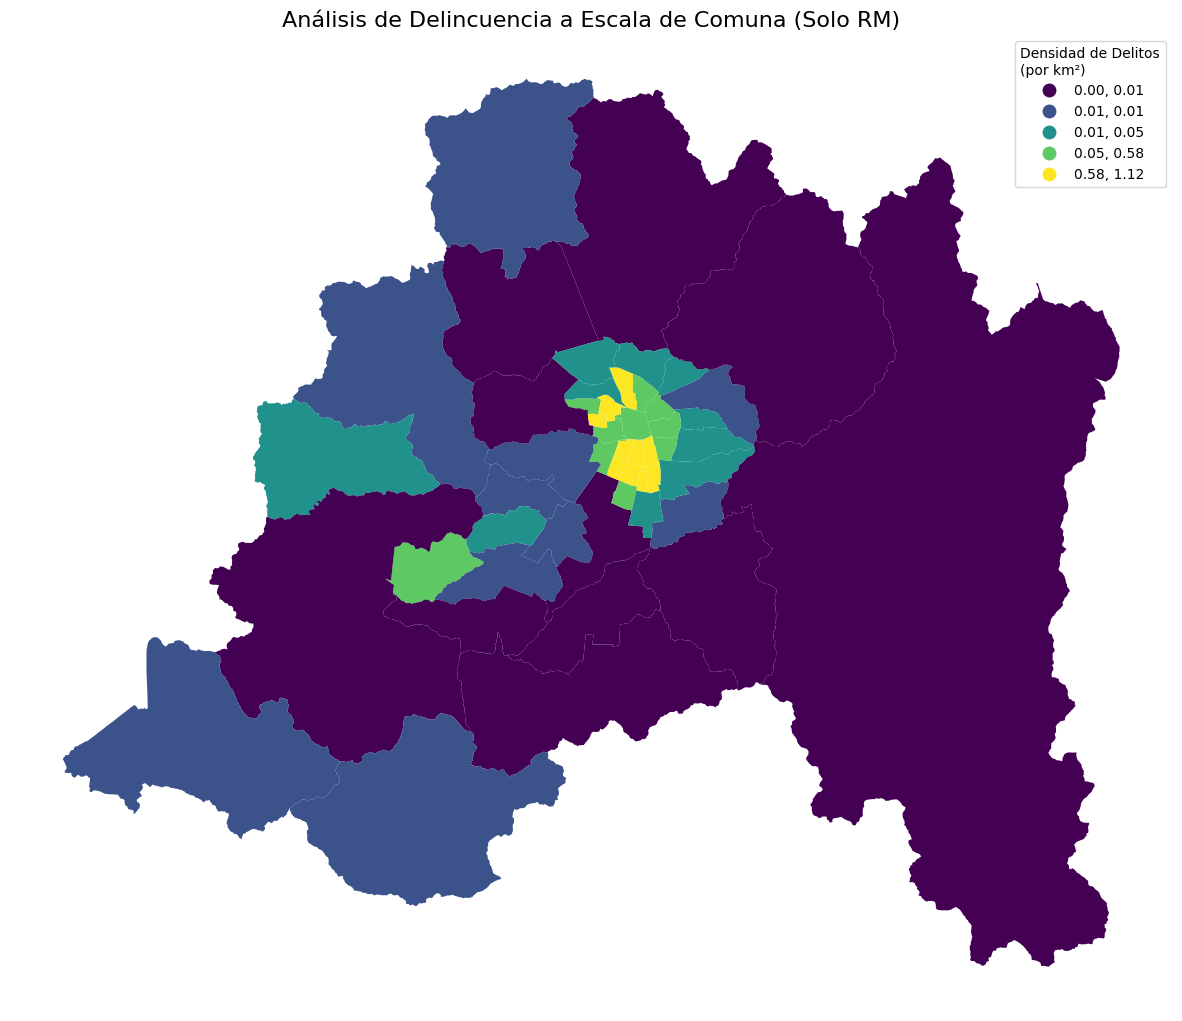

In [36]:
gdf_comunas = gpd.read_file('data/Comunas/comunas.shp')

gdf_comunas_rm = gdf_comunas[gdf_comunas['Region'] == 'Región Metropolitana de Santiago'].copy()

if gdf_comunas_rm.crs != gdf_delitos.crs:
    gdf_comunas_rm = gdf_comunas_rm.to_crs(gdf_delitos.crs)

nombre_columna_comuna = 'Comuna'

delitos_por_comuna_join = gpd.sjoin(gdf_comunas_rm, gdf_delitos, how="left", predicate="contains")
conteo_delitos_comuna = delitos_por_comuna_join.groupby(nombre_columna_comuna).size().reset_index(name='n_delitos')
gdf_comunas_final_rm = gdf_comunas_rm.merge(conteo_delitos_comuna, on=nombre_columna_comuna, how='left')

gdf_comunas_final_rm['n_delitos'] = gdf_comunas_final_rm['n_delitos'].fillna(0).astype(int)
gdf_comunas_final_rm['area_km2'] = gdf_comunas_final_rm.geometry.area / 10**6
gdf_comunas_final_rm['densidad_delitos'] = gdf_comunas_final_rm['n_delitos'] / gdf_comunas_final_rm['area_km2']

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf_comunas_final_rm.plot(column='densidad_delitos', ax=ax, legend=True, scheme='quantiles',
                       legend_kwds={'title': "Densidad de Delitos\n(por km²)"})
ax.set_title('Análisis de Delincuencia a Escala de Comuna (Solo RM)', fontsize=16)
ax.set_axis_off()
plt.show()

El mismo proceso pero a escala distrital

/tmp/ipython-input-2603071051.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.41981775e+00 8.57147837e-01 1.96432451e+00 1.31278645e+00
 1.30585341e+00 1.61663157e+00 1.79594389e+00 1.49638332e+00
 1.22260408e+00 1.68720778e+00 1.00321927e+00 1.59553318e+00
 1.14979290e+00 1.47513768e+00 1.27711485e+00 1.37198490e+00
 9.84507693e-01 1.47883658e+00 1.25417597e+00 9.79071762e-01
 1.07185685e+00 7.05095315e-01 9.25996843e-01 9.74380981e-01
 1.75355271e+00 2.00166767e+00 1.24636906e+00 1.46163021e+00
 1.36442648e+00 1.24032579e-01 6.36039350e-01 3.90445125e-01
 2.20902519e-01 5.60856354e-01 8.33981811e-01 1.27771332e+00
 1.35745932e+00 1.33963116e+00 1.19258521e+00 7.57762557e-01
 1.03270005e+00 3.56460802e-01 1.19645978e+00 7.28248190e-01
 8.55747498e-01 1.15180682e+00 6.51440952e-01 1.18409681e+00
 1.15823296e+00 7.10271196e-01 9.29215159e-01 1.03414048e+00
 2.32010442e-01 1.03034247e+00 1.31018670e

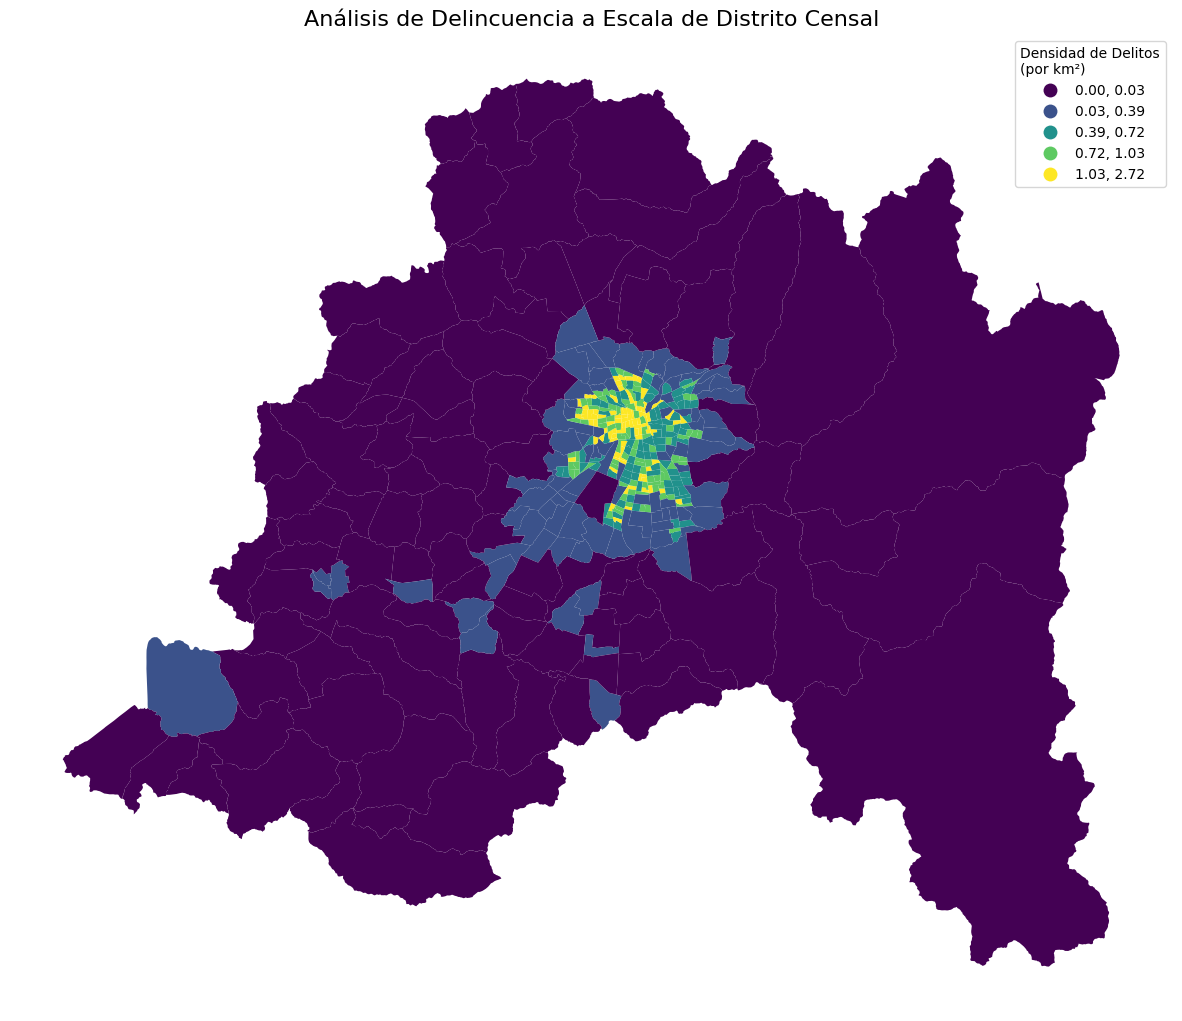

In [37]:
areas_final['area_km2'] = areas_final.geometry.area / 10**6
areas_final['densidad_delitos_distrito'] = 0
mask = areas_final['area_km2'] > 0
areas_final.loc[mask, 'densidad_delitos_distrito'] = areas_final['n_delitos'] / areas_final['area_km2']

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
areas_final.plot(column='densidad_delitos_distrito', ax=ax, legend=True, scheme='quantiles',
                 legend_kwds={'title': "Densidad de Delitos\n(por km²)"})
ax.set_title('Análisis de Delincuencia a Escala de Distrito Censal', fontsize=16)
ax.set_axis_off()
plt.show()

Como conclusion la escala distrital es mucho mejor para tomar decisiones para enfrentar delincuencia, nos da un mayor detalle de densidad de delitos ya que no en todos los distritos de una comuna hay igual cantidad de hogares, es por esto que el mapa tiene diferencias de color en zonas de la misma comuna para los distritos.